# SAS DLPy Image Classification Examples: Dolphin vs. Giraffe

The following series of examples perform image classification tasks using the SAS DLPy API. The examples use different versions and sources of CNN models. The [Model1](#Model1) example manually creates a simple CNN architecture. The [Model2](#Model2), [Model3](#Model3), and [Model4](#Model4) examples import different CNN architectures (for instance, ResNet50) along with their pre-trained weights. Unlike Model2, Model3, and Model4, [Model5](#Model5) loads a CNN architecture from a SAS table.  

All of the examples use Dolphin vs. Giraffe images for the classification tasks. The images are from 'animals with attributes 2', a free dataset at https://cvml.ist.ac.at/AwA2/. 

All examples require the SAS computing environment to be configured. This includes CAS (SAS Cloud Analytic Services) server sessions as well as Python requirements, including loading required DLPy functions and a plotting library. 

The collection contains configuration instructions and 5 SAS DLPy model examples: 

* [Set Up SAS Computing Environment for DLPy Examples](#Setup)

* [Model1](#Model1) example is a simple CNN model designed to classify the input images as either a dolphin or giraffe. This example includes a heatmap analysis to visualize what is important in an image according to the trained model. The example also include feature map generation, and how to save models to ASTORE.

* [Model2](#Model2) uses DLPy to import a pre-trained ResNet50 image classification model where the model weights are stored in a .h5 file. This example includes visualization of classification predictions.

* [Model3](#Model3) example uses DLPy to import a pre-trained VGG16 image classification model where the weights are stored in a .h5 file. This example includes a code snippet that shows how to use image features to fit a decision tree using SAS Pipefitter, as well as code that shows how to fit a PCA analysis using scikit-learn.

* [Model4](#Model4) example uses DLPy to import a pre-trained image classification ResNet50 model and perform transfer learning. The ResNet50 model uses weights are stored in a .h5 file. The Model4 example also includes heatmap analysis.

* [Model5](#Model5) example uses DLPy to load a pre-trained VGG16 model that was saved in a SAS table to perform image classification.

<h2 id="Setup">Set Up SAS Computing Environment for DLPy Examples <a name="Setup" /><a class="anchor-link" href="#Setup"></a></h2> 



All of the examples in this collection assume that your *PYTHONPATH* includes the SAS DLPy path (or installed) and an active CAS Server. You will need to perform the following tasks to configure your computing environment:


**Load Python Library** 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import swat

**Start a CAS Session**

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. 

<b>Note:</b> For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [2]:
host_name='your_host_name'
port_number=your_port_number
sess = swat.CAS( host_name, port_number)

## Load Images for DLPy Examples

In [3]:
from dlpy.images import ImageTable

After establishing an active SAS CAS session and importing the SWAT and DLPy modules, load the Dolphin vs. Giraffe images. The collection of DLPy examples all use the same image collection.

**Folder Structure for Dolphin vs. Giraffe Images**

The folder structure for the giraffe and dolphin images in the example is as follows:

   * Giraffe_Dolphin
       * Giraffe
           * Giraffe image 1
           * Girrafe image 2
           * ...
       * Dolphin
           * Dolphin image 1
           * Dolphin image 2
           * ...       
           
In the following code, the value for `img_path` represents a fully-qualified directory path to the images. The path must be accessible by the CAS server session.  

In [4]:
img_path='/disk/linux/dlpy/Giraffe_Dolphin'
my_images = ImageTable.load_files(sess, path=img_path)

The image table `my_images` now contains the images in the specified `path`.

**Verify Images in `my_images` Data Table**

Now we can verify that the `my_images` data table populated. Use the `head()` function to examine the first few rows. 

In [5]:
my_images.head()

Selected Rows from Table IMAGEDATA_IBVAJQ

                                             _image_  _label_  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  Giraffe   

         _filename_0  _id_  
0  giraffe_10001.jpg     1  
1  giraffe_10003.jpg     2  
2  giraffe_10018.jpg     3  
3  giraffe_10022.jpg     4  
4  giraffe_10035.jpg     5

Now, check some of the images in the data table. Display a table of 4 randomly selected training images from the image table `my_images`. 

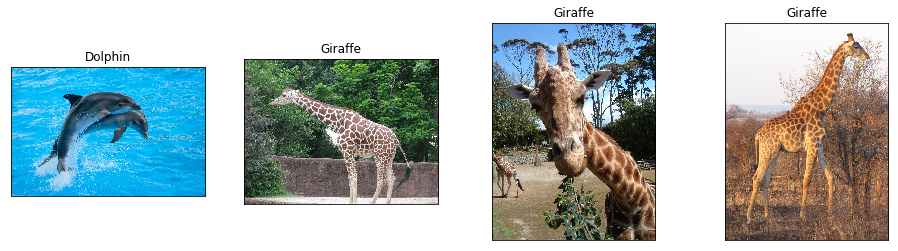

In [6]:
my_images.show(nimages=4, ncol=4, randomize=True)

What is the proportion of dolphin and giraffe images within the image table? Show a frequency analysis of the image table by label values: 

In [7]:
my_images.label_freq

Frequency for IMAGEDATA_IBVAJQ

         Level  Frequency
Dolphin      1        237
Giraffe      2        172

Now run an image summary to display image metadata from the table:

In [8]:
my_images.image_summary

jpg                   409
minWidth              170
maxWidth             1024
minHeight             127
maxHeight            1024
meanWidth         912.147
meanHeight        778.499
mean1stChannel    128.718
min1stChannel           0
max1stChannel         255
mean2ndChannel    124.123
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    94.2449
min3rdChannel           0
max3rdChannel         255
dtype: object

## Process Images for DLPy Examples

All of the DLPy examples in this collection use the Dolphin vs. Giraffe images to perform image classification tasks. Image data could be processed prior to model training. Image processing can include partitioning image data, standardizing image size parameters, and augmenting the image data to upsample the images in the training data. 

**Resize Input Image Dimensions**

The image processing task prepares the data for model training. The input images may not all be the same size. Deep learning models usually requires a fixed input size. The following Python code resizes all images to 224x224 pixels. As `height` is not explicitly provided, `height` is also resized to 224 and then, checks the resized images by displaying 4 of the images.

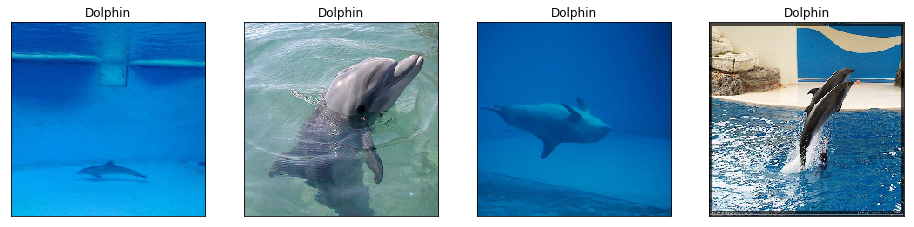

In [9]:
my_images.resize(width=224)
my_images.show(4, 4)

**Split Image Data into Training and Testing Partitions**



The code that follows partitions the data in the image table into two groups: a training image group and a testing image group. 80% of the data is allocated for training images `tr_img`, and the remaining 20% of the data is allocated for testing images `te_img`. The code uses a random seed value of `123` when selecting observations for partitioning.

In [10]:
## Splitting the Data into Training and Testing Partitions
from dlpy.splitting import two_way_split

In [11]:
tr_img, te_img = two_way_split(my_images, test_rate=20, seed=123)

**View Distibution of Dolphin and Giraffe Images in the Train and Test Data**

Now there are distinct train `tr_img` and test `te_img`images. Perform a label frequency analysis to show how the giraffe and dolphin images are distributedin the train and test data tables.

In [12]:
tr_img.label_freq

Frequency for TRAIN_S9E6AF

         Level  Frequency
Dolphin      1        190
Giraffe      2        138

In [13]:
te_img.label_freq

Frequency for TEST_H5DV8I

         Level  Frequency
Dolphin      1         47
Giraffe      2         34

**Augment the Training Data**

Data augmentation has become a standard precodure in image classification tasks. There are a number of different ways to apply data augmentation such as cropping, rotating, and flipping. In this case, we use cropping. 

The code below builds patches with size 200 x 200 pixels and then resizes them to 224 x 224 pixels. It does a sliding window approach with a step size of 24 pixels.

In [14]:
tr_img.as_patches(width=200, height=200, step_size=24, output_width=224, output_height=224)

Now display a frequency table of the augmented training data:

In [15]:
tr_img.label_freq

Frequency for TRAIN_S9E6AF

         Level  Frequency
Dolphin      1        760
Giraffe      2        552

After augmenting the data with cropping, the number of dolphin images in the data has increased from 190 to 760. The number of giraffe images in the training data has increased from 138 to 552.

Now use a table with 4 columns to display images from the augmented training data set. Note that all of the images in the augmented training data are 224 x 224 pixels.

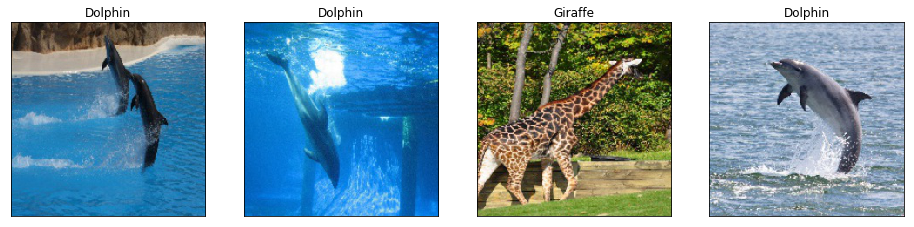

In [16]:
tr_img.show(4,4)

<h2 id="Model1">Model1: Simple CNN <a name="Model1" /><a class="anchor-link" href="#Model1"></a></h2>

### Build a simple CNN model

In [17]:
from dlpy import Sequential
from dlpy.model import *
from dlpy.layers import * 
from dlpy.applications import *

Now, you can build a simple convolutional neural network (CNN) model. 
Here the code imports functions and creates a sequential CNN model named `Simple_CNN`.

In [18]:
model1 = Sequential(sess, model_table='Simple_CNN')

The model is created and named. Now define the model architecture in DLPy. Begin by defining an input layer for a convolutional network with color images (3 channels) and images sized 224 pixels high by 224 pixels wide. The model will do a global constrast normlization using the mean values for each channel as the corresponding offset values for those channels. The mean pixel intensity values for each channel in the training data is found in a function `tr_img.channel_means`. 

**Add Input Layer**

In [19]:
model1.add(InputLayer(3, 224, 224, offsets=tr_img.channel_means))

NOTE: Input layer added.


The input layer in this CNN model is followed by a pair of layers: a 2-D convolution layer and a pooling layer. The convolution layer should have 8 filters and a kernel size of 7 x 7. The pooling layer should have a size of 2 by 2.

**Add 2-D Convolution Layer and Pooling Layer**

In [20]:
model1.add(Conv2d(8, 7))
model1.add(Pooling(2))

NOTE: Convolution layer added.
NOTE: Pooling layer added.


Continue to define the CNN architecture by inserting an additional pair of 2-D convolution and pooling layers. The second set of 2-D convolution and pooling layers uses the same parameter values as the first set of 2-D convolution and pooling layers: 8 filters and a kernel size of 7 x 7 for convolution, and a pooling layer with a size of 2 by 2.

**Add Another 2-D Convolution Layer and Pooling Layer**

In [21]:
model1.add(Conv2d(8, 7))
model1.add(Pooling(2))

NOTE: Convolution layer added.
NOTE: Pooling layer added.


Further define the CNN architecture by following the last pooling layer with a fully connected (dense) layer. The fully connected layer contains 16 neurons.

**Add Fully Connected (Dense) layer**

In [22]:
model1.add(Dense(16))

NOTE: Fully-connected layer added.


Complete the CNN model architecture by specifying the output layer. The output layer uses the Softmax activation function and has 2 neurons (matching the number of classes in the training data).

**Add Output layer**

In [23]:
model1.add(OutputLayer(act='softmax', n=2))

NOTE: Output layer added.
NOTE: Model compiled successfully.


After creating and naming the CNN model, defining the model architecture, and successfully compiling the model in DLPy, display a tabular summary of the compiled model.

In [24]:
model1.print_summary()

Layer    Type  Kernel Size Stride Activation    Output Size  \
0   Input1   input         None   None       None  (224, 224, 3)   
1  Convo.1   convo       (7, 7)      1       Relu  (224, 224, 8)   
2    Pool1    pool       (2, 2)      2        Max  (112, 112, 8)   
3  Convo.2   convo       (7, 7)      1       Relu  (112, 112, 8)   
4    Pool2    pool       (2, 2)      2        Max    (56, 56, 8)   
5    F.C.1      fc  (25088, 16)   None       Relu             16   
6  Output1  output      (16, 2)   None    Softmax              2   
7                                                                  

  Number of Parameters  
0               (0, 0)  
1            (1176, 8)  
2               (0, 0)  
3            (3136, 8)  
4               (0, 0)  
5          (401408, 0)  
6              (32, 2)  
7               405770

Use the Graphviz utility (installed with DLPy) to display a plot, or Directed Acyclic Graph (DAG) of the model network. 

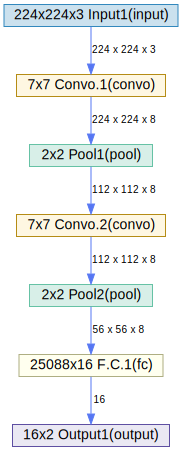

In [25]:
model1.plot_network()

### Model1: Train Network Using Augmented Data

The following code trains the CNN model using the augmented training data, a mini-batch size of 2, a maximum of 5 epochs, and a learning rate of 0.0001, using 1 GPU (GPU1). 

<b>Note:</b> The total number of mini-batches used in the optimization is computed as (mini-batch size * number of threads * number of workers). In this case, the number of threads is 32, and the number of workers is 1.)

In [26]:
model1.fit(data=tr_img, 
           mini_batch_size=2, 
           max_epochs=5, 
           lr=1E-4, 
           gpu=Gpu(devices=[1]), 
           log_level=2)

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Only 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 405786.
NOTE:  The approximate memory cost is 1001.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.77 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 2.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001           1.167     0.1387    

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                    simple_cnn
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                             7
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                             2
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             1
 8                 Number of Weight Parameters                        405752
 9                   Number of Bias Parameters                            34
 10           Total Number of Model Parameters                        405786
 11  Approximate Memory Cost for Training (MB)                          1001

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError
 0      1        0.0001  1.166900  0.138720
 1      2        0.0001  0.145040  0.070122
 2      3        0.0001  0.130477  0.066311
 3      4        0.0001  0.106502  0.054878
 4      5        0.0001  0.096979  0.051829

[OutputCasTables]

             casLib                Name    Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  Simple_CNN_weights  405786        3   
 
                                             casTable  
 0  CASTable('Simple_CNN_weights', caslib='CASUSER...  

+ Elapsed: 4.96s, user: 20.1s, sys: 2.33s, mem: 1.05e+03mb

### Summarize the training history

It is useful to visualize model training parameters across epochs. You can print a table of summary as follows:

In [27]:
model1.training_history

Epoch  LearningRate      Loss  FitError
0      1        0.0001  1.166900  0.138720
1      2        0.0001  0.145040  0.070122
2      3        0.0001  0.130477  0.066311
3      4        0.0001  0.106502  0.054878
4      5        0.0001  0.096979  0.051829

Alternatively, you can visualize the training history in a plot as follows:

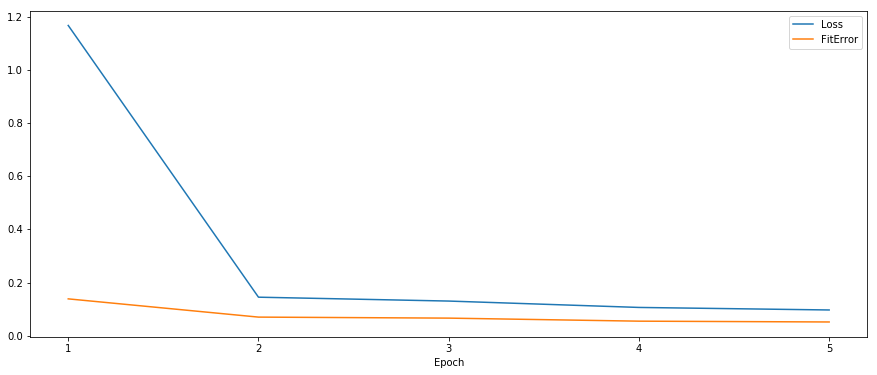

In [28]:
model1.plot_training_history(fig_size=(15, 6))

### Model1: Score Input Images

Now use the trained model to score input images. Use the test data `te_img` that was partitioned earlier in the example.  

In [29]:
model1.evaluate(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            81
 1  Number of Observations Used            81
 2  Misclassification Error (%)      3.703704
 3                   Loss Error       0.14728

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  Valid_Res_j7G8tz    81        9   
 
                                             casTable  
 0  CASTable('Valid_Res_j7G8tz', caslib='CASUSER(e...  

+ Elapsed: 0.718s, user: 9.79s, sys: 3.03s, mem: 2.71e+03mb

Visualize the performance of the classification model by creating a confusion matrix. A confusion matrix compares the predicted classes of true positives, false negatives, false positives, and true negatives. In this example, the matrix is a two-row cross-tabulation chart for Dolphin and Giraffe. Column 1 values reflect the number of predicted Dolphin images, and column 2 values reflect the number of predicted Giraffe images. The code is as follows:

In [30]:
model1.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2
 0  Dolphin  44.0   3.0
 1  Giraffe   0.0  34.0

+ Elapsed: 0.00874s, user: 0.00876s, sys: 0.0122s, mem: 3.83mb

The confusion chart data looks pretty good: a relatively large number of correct classifications as compared to a relatively small number of misclassifications.

The image classification results can also be plotted for a different visualization. The following code displays a plot with 2 random images that were correctly classified (actual class=predicted class), along with a predicted probability bar chart for each image.


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(ethem_kinginthenorth).


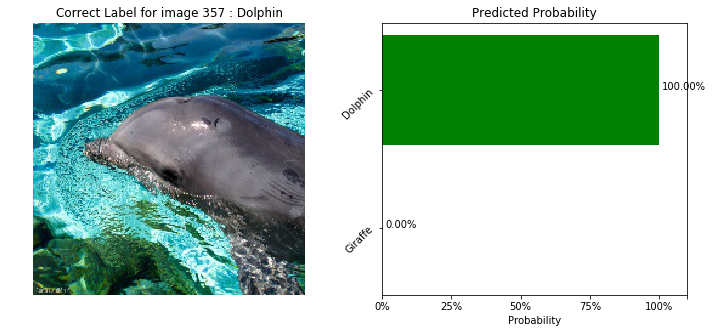

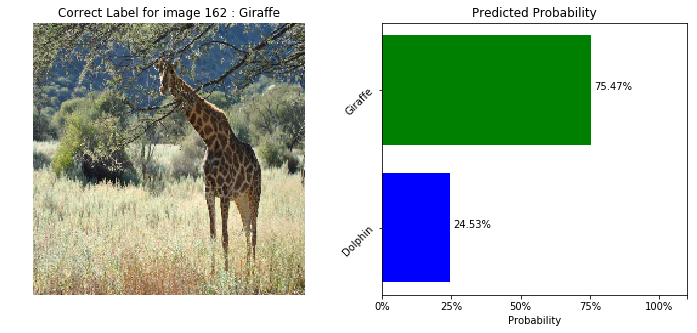

In [31]:
model1.plot_evaluate_res(img_type='C', randomize=True, n_images=2)

### Model1: Perform Heatmap Analysis

Heat maps are visualization tools that use color to indicate different values of interest. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps visualize which parts of an image are most useful to the model when predicting the class.  

The following code to generate heat maps uses the score results from the CNN network model1. The analysis focuses on a 56 x 56 pixel mask over the image using a step size of 8 pixels. The 'max display' setting in the code limits the heat map output to two rows, where each row displays the heat map information for a random image. 

Using results from model.predict()
NOTE: The number of images in the table is too large, only 2 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_FJCUVS contains compressed images.


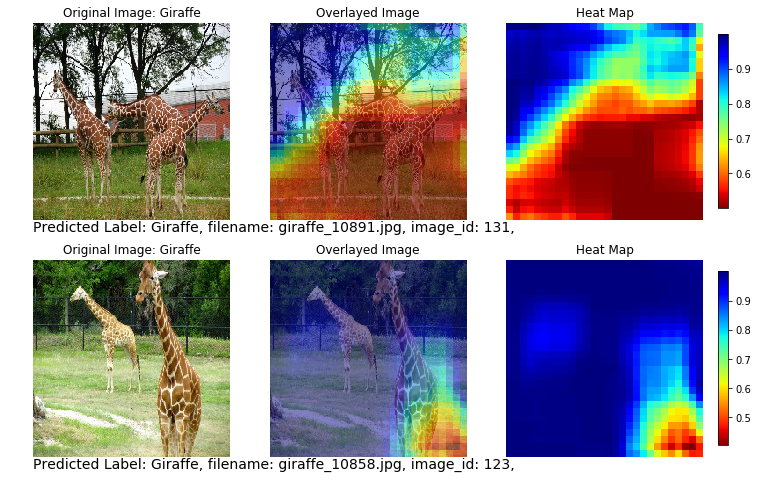

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_FJCuvs from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Giraffe          0.045386          0.954614  giraffe_10891.jpg  131   
1   Giraffe          0.000483          0.999517  giraffe_10858.jpg  123   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Giraffe   

                                            heat_map  
0  [[0.9999655485153198, 0.9999655485153198, 0.99...  
1  [[0.9978742599487305, 0.9978742599487305, 0.99...

In [32]:
model1.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, max_display=2)

###  Model1: View Feature Maps

Feature maps display the output activations for a given filter.
The following code uses the test data from the Model1 example to generate and display feature map data. First, create the feature map data. This example uses the test data and filters for images labeled `Dolphin`. The `idx=0` setting indicates that the row 0 index data should be used to construct the feature maps.

In [33]:
model1.get_feature_maps(data=te_img, label='Dolphin', idx=0)

Now display the feature map data for different layers in the network architecture. The following code displays feature maps for layer 0, or the input layer of Model1.


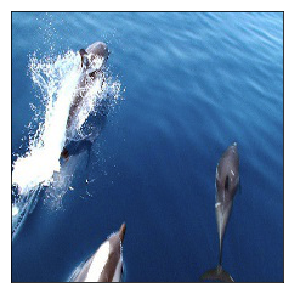

In [34]:
model1.feature_maps.display(layer_id=0)

Next, submit code to display the feature, or activation maps for the second layer in model1. In our model this layer is a 2-D convolution layer with 8 filters. The output should display a feature map for each filter.


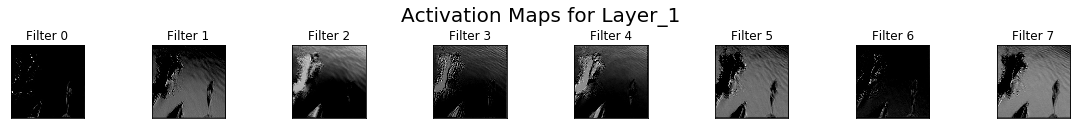

In [35]:
model1.feature_maps.display(layer_id=1)

The next line of code displays the feature map for the third layer in model1. The third layer is a pooling layer that has 8 filters. The output will also include 8 activation maps.

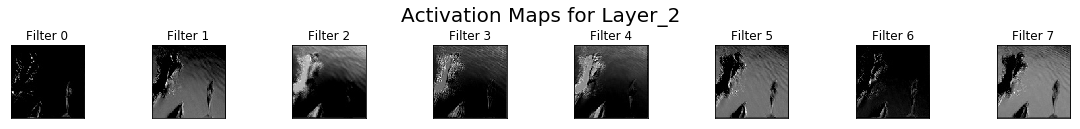

In [36]:
model1.feature_maps.display(layer_id=2)

The next line of code displays the activation maps for the fifth layer of the model1 network. The fifth layer of model1 is a pooling layer that has 8 filters. The code and output is as follows: 

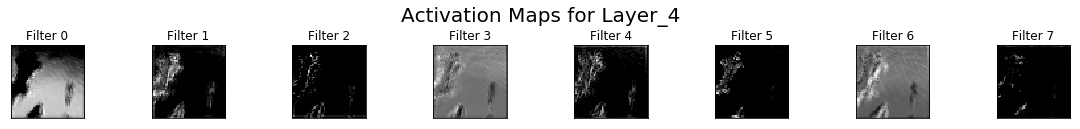

In [37]:
model1.feature_maps.display(layer_id=4)

### Model1: Save to ASTORE

Now save the Model1 CNN model using the ASTORE format. The ASTORE format allows you to deploy your saved model in another environment. When `astore` is specified, the model is saved to specified directory.

The following code will save the ASTORE version of 'model1' to the specified path.

In [39]:
model1.deploy(path='/disk/lax/dlpy/', output_format='astore')

NOTE: Model astore file saved successfully.


It is useful to save models in the `.sashdat` (SAS Hadoop Data Table) format in order to faciliate reloading the models for later access. For example, you might want to retrain the model later with updated data, or use the model for transfer learning.  

To save in `.sashdat` format, specify the output_format `table` option in the `deploy()` syntax. The `.sashdat` model is saved to the specified directory in the following code.

In [41]:
model1.deploy(path='/disk/lax/dlpy', output_format='table')

NOTE: Model table saved successfully.


<h2 id="Model2">Model2: ImageNet Analysis Using Imported Caffe ResNet50 Model <a name="Model2" /><a class="anchor-link" href="#Model2"></a></h2>

DLPy can import pre-defined models along with pre-trained weights from other libraries such as Keras and Caffe. This example performs an ImageNet analysis using a Caffe ResNet50 model with a pre-trained `.h5` weight file. This example DLPy model is saved as 'model2'.

This example requires access to a ResNet50_Caffe library model, including the associated `.h5` file that contains the associated trained model weights (see https://github.com/BVLC/caffe/wiki/Model-Zoo for Caffe details).

In [44]:
from dlpy.applications import ResNet50_Caffe, VGG16

The following code snipped is used to create a pre-defined ResNet50 model along with model weights trained on the ImageNet 1K dataset.

* Use pre-trained weights.
* Pre-trained weights are stored on the server at '/disk/linux/dlpy'
* The name of the pre-trained weights file in the defined path is 'ResNet-50-model.caffemodel.h5'.
* Name the model table 'RESNET50_CAFFE'.
* Do not use a batch normalization layer before the convolutional layer in the residual block. 
* 1000 object classes
* BGR color images, so n_channels=3
* Images 224 px high by 224 px wide
* Do not flip or crop existing images for augmentation.
* Set BGR offsets to 103.939, 116.779, 123.68. These are the default offset values for each input channel.
* Use pretrained weights as defined in the specified .h5 file.
* Include fully trained weights in the top (fully connected) layers.

In [42]:
# pre_train_weight_file is a fully qualified directory for your model weights.
# Please refer to Example 2 - Pre-trained Models and Transfer Learning.ipynb for more details.

PRE_TRAIN_WEIGHT_LOC = '/disk/linux/dlpy/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'ResNet-50-model.caffemodel.h5')

model2 = ResNet50_Caffe(sess, model_table='RESNET50_CAFFE', batch_norm_first=False,
                        n_classes=1000, n_channels=3, width=224, height=224, scale=1,
                        random_flip='none', random_crop='none',
                        offsets=(103.939, 116.779, 123.68),
                        pre_trained_weights=True, 
                        pre_trained_weights_file=pre_train_weight_file,
                        include_top=True)

NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_RV2MNK in caslib CASUSER(ethem_kinginthenorth).
NOTE: The table NEW_LABEL_TABLE_RV2MNK has been created in caslib CASUSER(ethem_kinginthenorth) from binary data uploaded to Cloud Analytic Services.
NOTE: Model weights attached successfully!


Use the `print_summary()` function to browse a summary of the newly imported `model2` parameters and architecture:

In [43]:
model2.print_summary()

Layer       Type   Kernel Size Stride Activation  \
0              data      input          None   None       None   
1             conv1      convo        (7, 7)      2   Identity   
2          bn_conv1  batchnorm          None   None  Rectifier   
3             pool1       pool        (3, 3)      2        Max   
4    res2a_branch2a      convo        (1, 1)      1   Identity   
5     bn2a_branch2a  batchnorm          None   None  Rectifier   
6    res2a_branch2b      convo        (3, 3)      1   Identity   
7     bn2a_branch2b  batchnorm          None   None  Rectifier   
8    res2a_branch2c      convo        (1, 1)      1   Identity   
9     bn2a_branch2c  batchnorm          None   None   Identity   
10    res2a_branch1      convo        (1, 1)      1   Identity   
11     bn2a_branch1  batchnorm          None   None   Identity   
12            res2a   residual          None   None  Rectifier   
13   res2b_branch2a      convo        (1, 1)      1   Identity   
14    bn2b_branch2a  batchnorm          None   None  Rectifier   
15   res2b_branch2b      convo        (3, 3)      1   Identity   
16    bn2b_branch2b  batchnorm          None   None  Rectifier   
17   res2b_branch2c      convo        (1, 1)      1   Identity   
18    bn2b_branch2c  batchnorm          None   None   Identity   
19            res2b   residual          None   None  Rectifier   
20   res2c_branch2a      convo        (1, 1)      1   Identity   
21    bn2c_branch2a  batchnorm          None   None  Rectifier   
22   res2c_branch2b      convo        (3, 3)      1   Identity   
23    bn2c_branch2b  batchnorm          None   None  Rectifier   
24   res2c_branch2c      convo        (1, 1)      1   Identity   
25    bn2c_branch2c  batchnorm          None   None   Identity   
26            res2c   residual          None   None  Rectifier   
27   res3a_branch2a      convo        (1, 1)      2   Identity   
28    bn3a_branch2a  batchnorm          None   None  Rectifier   
29   res3a_branch2b      convo        (3, 3)      1   Identity   
..              ...        ...           ...    ...        ...   
97    bn4f_branch2b  batchnorm          None   None  Rectifier   
98   res4f_branch2c      convo        (1, 1)      1   Identity   
99    bn4f_branch2c  batchnorm          None   None   Identity   
100           res4f   residual          None   None  Rectifier   
101  res5a_branch2a      convo        (1, 1)      2   Identity   
102   bn5a_branch2a  batchnorm          None   None  Rectifier   
103  res5a_branch2b      convo        (3, 3)      1   Identity   
104   bn5a_branch2b  batchnorm          None   None  Rectifier   
105  res5a_branch2c      convo        (1, 1)      1   Identity   
106   bn5a_branch2c  batchnorm          None   None   Identity   
107   res5a_branch1      convo        (1, 1)      2   Identity   
108    bn5a_branch1  batchnorm          None   None   Identity   
109           res5a   residual          None   None  Rectifier   
110  res5b_branch2a      convo        (1, 1)      1   Identity   
111   bn5b_branch2a  batchnorm          None   None  Rectifier   
112  res5b_branch2b      convo        (3, 3)      1   Identity   
113   bn5b_branch2b  batchnorm          None   None  Rectifier   
114  res5b_branch2c      convo        (1, 1)      1   Identity   
115   bn5b_branch2c  batchnorm          None   None   Identity   
116           res5b   residual          None   None  Rectifier   
117  res5c_branch2a      convo        (1, 1)      1   Identity   
118   bn5c_branch2a  batchnorm          None   None  Rectifier   
119  res5c_branch2b      convo        (3, 3)      1   Identity   
120   bn5c_branch2b  batchnorm          None   None  Rectifier   
121  res5c_branch2c      convo        (1, 1)      1   Identity   
122   bn5c_branch2c  batchnorm          None   None   Identity   
123           res5c   residual          None   None  Rectifier   
124           pool5       pool        (7, 7)      7       Mean   
125          fc1000     output  (2048, 1000)   None   

**Note:** This is a large and deep network with around 25 million parameters!!!

Normally it is a good idea to visualize models. However, this ResNet50 model is large and deep, and visualizations would be processor-burdened and messy. This example skips the model visualization task. Thougn not recommended, one can visualize 'model2' by uncommenting and submitting the following code:

In [44]:
#resnet50 is a deep network so skipping the visualization of it here:)
#model2.plot_network()

### Model2: Evaluate Pretrained Network Using Dolphin and Giraffe Images

ImageNet is an image database organized according to the WordNet hierarchy. Established Caffe libraries contain data for the ImageNet ILSVRC2012 classes, including semantic image labels. There are 1,000 image classes in the ILSVRC2012 classes, and each class has its own image label. They are referred to as the ImageNet 1k labels.  

Now use `model2` to score the `my_images` data, using the ImageNet1K label set. Execute using one of the two GPUs available: GPU0 and GPU1.

The next step uses the `plot_evaluate_res()` function to create bar charts of the classification predictions. In the charts, top 5 predictions are visualized along with their probabilities.

By default, the function generates plots for `n_images=3`. Setting `img_type=A` means that all classifications (correct or incorrect) are eligible for plotting. 


NOTE: Only 1 out of 2 available GPU devices are used.
NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(ethem_kinginthenorth).


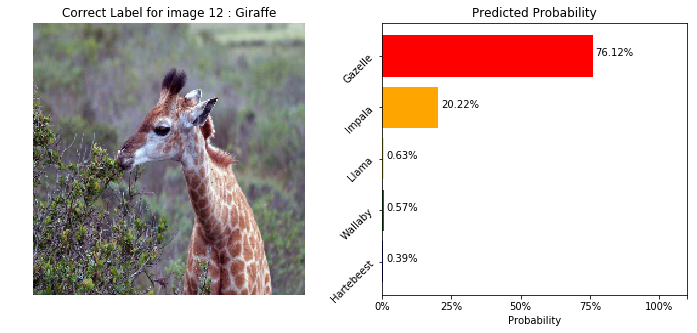

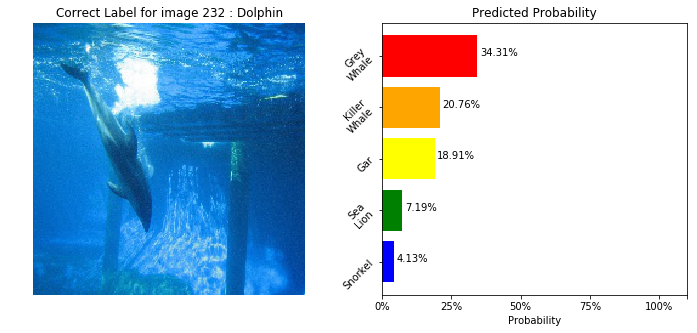

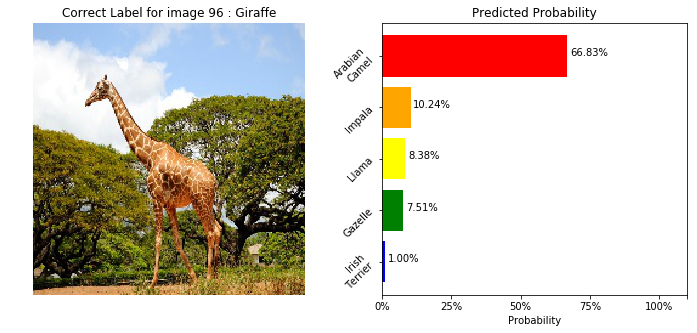

In [49]:
model2.predict(data=my_images, gpu=Gpu(devices=[1]))
model2.plot_evaluate_res(img_type='A', n_images=3, randomize=True)

The scored data does not have exact matches. There is a good reason for this: the ImageNet1K data includes 1,000 labeled classes, but there is no labeled class for dolphin or giraffe. Therefore none of the ImageNet1K classes could be a true prediction.

What happens when the label data for a scoring model does not include a true class for the object in an image? In these cases, the model tends to predict the most semantically similar classification. 



<h2 id="Model3">Model3: Using Feature Maps for Decision Trees and Principal Component Analysis (PCA) <a name="Model3" /><a class="anchor-link" href="#Model3"></a></h2>


Interim results from a deep neurel architecture can also be used with different machine learning algorithms. 

In classic image analytics, images were represented by feature descriptors. In other words, pixels are quantified into a collection of features that represent an image. These feature descriptors can then be used in machine learning algorithms,  such as SVM or decision trees. 

In the Model3 example, images are represented as feature maps that are calculated using a pre-defined VGG16 model with pre-trained weights trained on the ImageNet1K dataset.

### Model3: Use DLPy to Import Caffe VGG16 Model and Pre-Trained Model Weights File

This example requires access to a VGG16_Caffe library model, including the associated `.h5` file that contains the trained model weights. The Caffe Model Zoo https://github.com/BVLC/caffe/wiki/Model-Zoo framework provides tools that you can use to download `.caffemodel` and `.caffemodelh5` binaries.

The following code specifies the path to the `.h5` file that contains the pre-trained weights for the VGG16 network. Then the code defines the following 'model3' VGG16 parameter settings:

* Use pre-trained weights.
* Pre-trained weights are stored on the server at '/disk/linux/dlpy'
* The name of the pre-trained weights file in the defined path is 'VGG_ILSVRC_16_layers.caffemodel.h5'.
* Name the model table 'VGG16'.
* 1000 object classes
* BGR color images, therefore n_channels=3
* Images 224 px high by 224 px wide
* Do not flip or crop existing random images for augmentation.
* Use default BGR input channel offsets of 103.939, 116.779, 123.68.
* Use pretrained weights as defined in the specified .h5 file.
* Include fully trained weights in the top (fully connected) layers.

In [50]:
# pre_train_weight_file is a fully qualified directory for you model weights.
# Please refer to Example 2 - Pre-trained Models and Transfer Learning.ipynb for more details.

PRE_TRAIN_WEIGHT_LOC = '/disk/linux/dlpy/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'VGG_ILSVRC_16_layers.caffemodel.h5')

model3 = VGG16(sess, model_table='VGG16', 
               n_classes=1000, n_channels=3, width=224, height=224, scale=1,
               random_flip='none', random_crop='none',
               offsets=(103.939, 116.779, 123.68),
               pre_trained_weights=True,
               pre_trained_weights_file=pre_train_weight_file,
               include_top=True)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_ZLPJUB in caslib CASUSER(ethem_kinginthenorth).
NOTE: The table NEW_LABEL_TABLE_ZLPJUB has been created in caslib CASUSER(ethem_kinginthenorth) from binary data uploaded to Cloud Analytic Services.
NOTE: Model weights attached successfully!


### Model3: Use ImageNet VGG16 Network to Extract Features Maps

Feature extraction is a valuable technique for image processing. DLPy supports the `get_features()` function that extracts features for a data table from a specified layer.

The code below extracts features from the test image data, using the `pool5` layer of VGG16 `model3`. 

In [52]:
X, y = model3.get_features(data=te_img, dense_layer='pool5')

In [53]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['Dolphin', 'Dolphin', 'Dolphin', 'Giraffe', 'Dolphin', 'Giraffe',
        'Dolphin', 'Giraffe', 'Giraffe', 'Giraffe', 'Dolphin', 'Dolphin',
        'Dolphin', 'Giraffe', 'Dolphin', 'Dolphin', 'Dolphin', 'Dolphin',
        'Dolphin', 'Dolphin', 'Dolphin', 'Dolphin', 'Dolphin', 'Dolphin',
        'Dolphin', 'Giraffe', 'Dolphin', 'Giraffe', 'Dolphin', 'Dolphin',
        'Dolphin', 'Dolphin', 'Giraffe', 'Dolphin', 'Giraffe', 'Dolphin',
        'Dolphin', 'Giraffe', 'Giraffe', 'Giraffe', 'Giraffe', 'Dolphin',
        'Dolphin', 'Dolphin', 'Giraffe', 'Giraffe', 'Giraffe', 'Giraffe',
        'Dolphin', 'Dolphin', 'Giraffe', 'Dolphin', 'Dolphin', 'Giraffe',
        'Giraffe', 'Giraffe', 'Dolphin', 'Dolphin', 'Dolphin', 'Dolphin',
        'Gi

The `get_features()` function returns two arrays in the output above. The first array is an n-dimensional array, where n is the sample size and p is the number of features extracted by the model at the specified `dense_layer`. The second array is is of size n and contains the response variable of the original data.

### Model3: Use SAS Pipefitter Utility to Fit a Decision Tree

Decision trees are powerful algorithms that are capable of fitting complex data sets used in image analysis. DLPy supports the SAS Pipefitter API.  Pipefitter provides a Python API for developing machine learning pipelines. The pipelines have stages that can perform various tasks: fit parameter estimates using machine learning techniques (e.g., decision trees), use hyperparameter tuning to speed model selection, score data and assess models.
perform variable transformation, parameter estimation, hyperparameter tuning, . 

For information and access to the SAS Pipefitter API, see https://github.com/sassoftware/python-pipefitter. 

The example code below imports pandas first: DataFrame structures are used. Next, the code imports the `HyperParameterTuning` class from the Pipefitter model selector. The `HyperParameterTuning` class tests a grid of model parameters and applies them to an estimator or a pipeline, then returns compiled results of various permutations of model parameters. 

Finally, the code imports the `DecisionTree`, `DecisionForest`, and `GBTree` classes from the Pipefitter estimator. When you add an estimator to a pipeline, the `fit()` method performs parameter estimation and generates a model. The pipeline returns a PipelineModel that includes the model.

In [54]:
import pandas as pd
from pipefitter.model_selection import HyperParameterTuning
from pipefitter.estimator import DecisionTree, DecisionForest, GBTree

The following code sets set target and input parameter values, defines depth limits for the decision tree to be created, sets up and loads the DataFrame, then fits a decision tree model. After the decision tree is created, it is used to score the image data.


In [55]:
params = dict(target='label', 
              inputs=[str(i) for i in range(16)])
dtree = DecisionTree(max_depth=6, **params)
data = pd.DataFrame(X)
data['label'] = y
data.columns = ['%s' % x for x in data.columns]
casdata = sess.upload_frame(data)
model = dtree.fit(casdata)
score = model.score(casdata)
score

NOTE: Cloud Analytic Services made the uploaded file available as table TMPYBRWMIQG in caslib CASUSER(ethem_kinginthenorth).
NOTE: The table TMPYBRWMIQG has been created in caslib CASUSER(ethem_kinginthenorth) from binary data uploaded to Cloud Analytic Services.


Target                       label
Level                        CLASS
Var                         _DT_P_
NBins                          100
NObsUsed                        81
TargetCount                     81
TargetMiss                       0
PredCount                       81
PredMiss                         0
Event                      Dolphin
EventCount                      47
NonEventCount                   34
EventMiss                        0
AreaUnderROCCurve         0.580726
KS                       0.0963705
KSCutOff                      0.21
MisClassificationRate      38.2716
CRCut                         0.21
ClassificationCutOff           0.5
dtype: object

The output shows that the resulting decision tree model scored the image data for the target event 'Dolphin'. 

###  Model3: Fit a Principal Component Analysis (PCA) Model using Scikit-learn


Principal component analysis (PCA) uses Singular Value Decomposition (SVD) to reduce the linear dimensionality of input data and projects it to a lower dimensional space. In the open-source scikit-learn package, PCA is implemented as a transformer object that learns n components in its fit method, and can be used on new data to project it on these components.

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

The following code generates principal component data for the dolphin and giraffe images. Next, the code defines plot boundaries and elements, then generates a scatter plot of the principal components (PC1 and PC2) for Giraffe and Dolphin classes. 

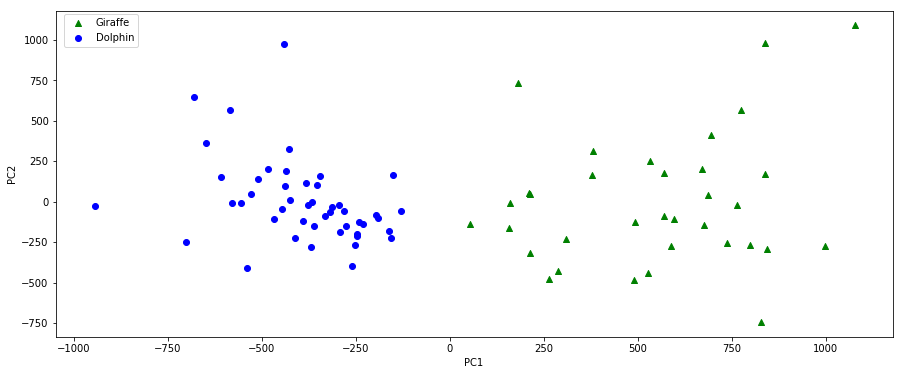

In [57]:
X_r = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(15, 6))
plt.scatter(X_r[y=='Giraffe',0], X_r[y=='Giraffe', 1], marker='^', c='g', label='Giraffe')
plt.scatter(X_r[y=='Dolphin',0], X_r[y=='Dolphin', 1], marker='o', c='b', label='Dolphin')
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


<h2 id="Model4">Model4:  Perform Transfer Learning with ImageNet ResNet50 <a name="Model4" /><a class="anchor-link" href="#Model4"></a></h2>


Transfer learning is a machine learning method where a model that was developed for one task is reused as the starting point for a model that is developed for a second, different task. This example uses DLPy to import an ImageNet ResNet50 Caffe model with pre-trained weights and saves the network as Model4.

This example requires access to a ResNet50_Caffe library model, including the associated `.h5` file that contains the trained model weights. The Caffe Model Zoo https://github.com/BVLC/caffe/wiki/Model-Zoo framework provides tools that you can use to download `.caffemodel` and `.caffemodelh5` binaries.


The following code first defines the path and name of the .h5 model weights, then defines a ResNet50 model with the following parameters:

* 2 classes (Dolphin and Giraffe)
* BGR color images, so n_channels=3
* Images 224 px high by 224 px wide
* Do not flip or crop existing images for augmentation.
* Set BGR offsets for each input channel to the channel mean values found in the training image set. 
* Use pretrained weights as defined in the specified .h5 file.
* Do not include fully trained weights in the top (fully connected) layers.

In [58]:
# pre_train_weight_file is a fully qualified directory for you model weights.
# Please refer to Example 2 - Pre-trained Models and Transfer Learning.ipynb for more details.

PRE_TRAIN_WEIGHT_LOC = '/disk/linux/dlpy/'
pre_train_weight_file = os.path.join(PRE_TRAIN_WEIGHT_LOC, 'ResNet-50-model.caffemodel.h5')

model4 = ResNet50_Caffe(sess, model_table='ResNet50_Caffe', 
                n_classes=2, n_channels=3, width=224, height=224, scale=1,
                random_flip='none', random_crop='none',
                offsets=tr_img.channel_means,
                pre_trained_weights=True, 
                pre_trained_weights_file=pre_train_weight_file,
                include_top=False)

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50_caffe" according to the model name in the table.


Now further train the model. The following code uses the training images with a mini-batch size of 1, for 1 epoch, and a learning rate of 0.005.

In [59]:
model4.fit(data=tr_img, 
           mini_batch_size=1,
           max_epochs=1, 
           lr=5E-3,  
           gpu=Gpu(devices=[1]))

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Only 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 23512194.
NOTE:  The approximate memory cost is 566.00 MB.
NOTE:  Loading weights cost       0.22 (s).
NOTE:  Initializing each layer cost       1.98 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Training)
NOTE:      0    32    

[ModelInfo]

                                         Descr                         Value
 0                                  Model Name                resnet50_caffe
 1                                  Model Type  Convolutional Neural Network
 2                            Number of Layers                           126
 3                      Number of Input Layers                             1
 4                     Number of Output Layers                             1
 5              Number of Convolutional Layers                            53
 6                    Number of Pooling Layers                             2
 7            Number of Fully Connected Layers                             0
 8        Number of Batch Normalization Layers                            53
 9                   Number of Residual Layers                            16
 10                Number of Weight Parameters                      23459008
 11                  Number of Bias Parameters                         53186
 12           Total Number of Model Parameters                      23512194
 13  Approximate Memory Cost for Training (MB)                           566

[OptIterHistory]

    Epoch  LearningRate      Loss  FitError
 0      1         0.005  0.154748  0.047256

[OutputCasTables]

             casLib                    Name      Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  resnet50_caffe_weights  23565314        3   
 
                                             casTable  
 0  CASTable('resnet50_caffe_weights', caslib='CAS...  

+ Elapsed: 8.43s, user: 24.6s, sys: 3.24s, mem: 641mb

### Model4: Score Test Data

Now use model4 to score input data.

In [60]:
model4.evaluate(data=te_img ,  gpu=Gpu(devices=[1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Only 1 out of 2 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            81
 1  Number of Observations Used            81
 2  Misclassification Error (%)             0
 3                   Loss Error      0.022678

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  Valid_Res_Qif48I    81        9   
 
                                             casTable  
 0  CASTable('Valid_Res_Qif48I', caslib='CASUSER(e...  

+ Elapsed: 3.31s, user: 8.16s, sys: 1.24s, mem: 918mb

The trained model4 performs very well when scoring the test data. 100% (81 of 81) of the images in the test data were correctly classified. 

The following code generates a confusion matrix that illustrates the classification prediction accuracy. 

In [61]:
model4.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2
 0  Dolphin  47.0   0.0
 1  Giraffe   0.0  34.0

+ Elapsed: 0.0105s, user: 0.0101s, sys: 0.0157s, mem: 4.07mb

You can see that 47 dolphin images and 34 giraffe images were correctly classified, for a total of 81
correctly classified images.  The confusion matrix also shows that there were no misclassifications 
when scoring the test images.

The next step visualizes some of the image predictions from the test data. The function 
`plot_evaluate_res()` creates bar charts of 2 random individual classification predictions. Setting 
`img_type='A'` in the following code means that all classifications (either correct or incorrect) are eligible 
for plotting. In this example, all of predictions are correct.


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(ethem_kinginthenorth).


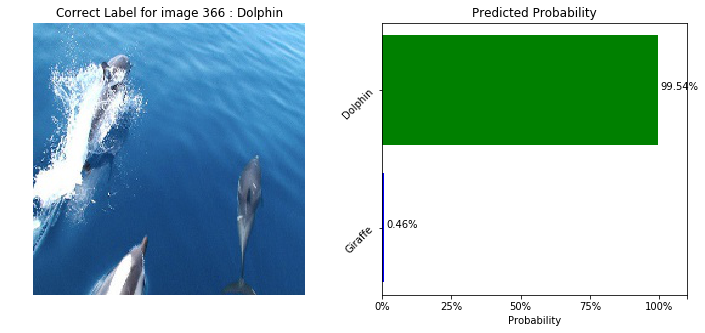

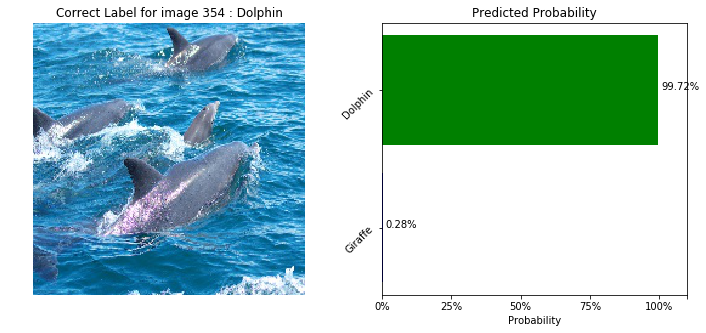

In [62]:
model4.plot_evaluate_res(img_type='A', randomize=True, n_images=2)

### Model4: Perform Heatmap Analysis

Heat maps are visualization tools that use color to indicate different values of interest. In this case, the most important regions of an image are the regions that provide the most useful information to the model, enabling it to determine a distinction of the actual class. In other words, heat maps visualize which parts of an image are most useful to the model when predicting the class.

The following code to generate heat maps uses the score results from the CNN network model1. The analysis focuses on a 56 x 56 pixel mask over the image using a step size of 8 pixels. The 'max display' setting in the code limits the heat map output to two rows, where each row displays the heat map information for a random image.

Using results from model.predict()
NOTE: The number of images in the table is too large, only 2 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_Z76YOB contains compressed images.


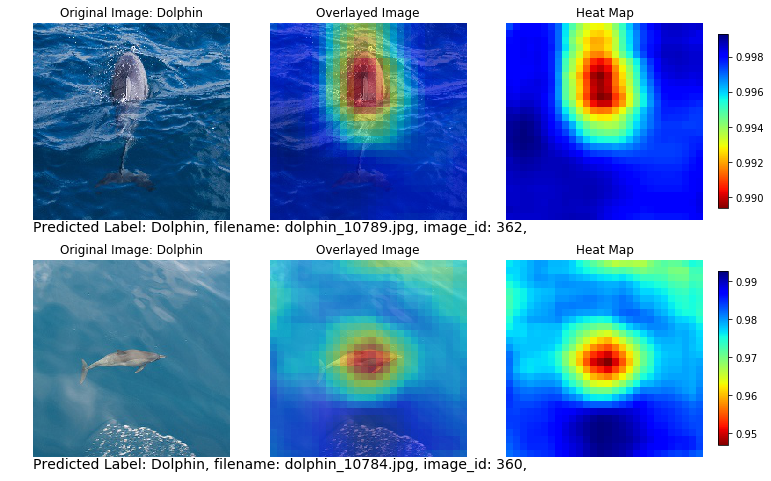

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_Z76yob from caslib CASUSER(ethem_kinginthenorth).


I__label_  P__label_Dolphin  P__label_Giraffe        _filename_0 _id_  \
0   Dolphin          0.999140          0.000860  dolphin_10789.jpg  362   
1   Dolphin          0.964273          0.035727  dolphin_10784.jpg  360   

                                             _image_  _label_  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Dolphin   

                                            heat_map  
0  [[0.9973347187042236, 0.9973347187042236, 0.99...  
1  [[0.9764427542686462, 0.9764427542686462, 0.97...

In [63]:
model4.heat_map_analysis( mask_width=56, mask_height=56, step_size=8, max_display=2)


<h2 id="Model5">Model5: Load A Pre-Trained VGG16 Model From .sashdat Table File <a name="Model5" /><a class="anchor-link" href="#Model5"></a></h2> 

It is useful to save models in the `.sashdat` (SAS Hadoop Data Table) format in order to faciliate reloading the models for later access. For example, you might want to retrain the model later with updated data, or use the model for transfer learning.  

The following code uploads a pre-trained VGG16 model that was saved as a `.sashdat` table, and names it `model5`. 

In [64]:
model5 = Model(sess)

# model_file is a fully-qualified server-side directory for your model file.
# The associated weight and attribute files are all in the same directory.
# You need to modify the path according to your own environment.

model_file = '/disk/linux/dlpy/vgg16.sashdat'

model5.load(path=model_file)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "vgg16" according to the model name in the table.
NOTE: vgg16_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: vgg16_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


## Model5: Score Test Images

After importing the pre-trained VGG16 model with weights as `model5`, evaluate the effectiveness of the imported model by using it to score the dolphin and giraffe test images:

In [65]:
model5.evaluate(te_img)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            81
 1  Number of Observations Used            81
 2  Misclassification Error (%)             0
 3                   Loss Error      0.003724

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem_kinginthenorth)  Valid_Res_NYzx6o    81        9   
 
                                             casTable  
 0  CASTable('Valid_Res_NYzx6o', caslib='CASUSER(e...  

+ Elapsed: 11.9s, user: 198s, sys: 34.9s, mem: 1.76e+04mb

The imported model performs well. 81 of 81 images in the test data set were correctly classified.

We can view the distribution of the correctly classified images with a confusion matrix. In this example, the matrix is a two-row cross-tabulation chart for Dolphin and Giraffe. Column 1 values reflect the number of predicted Dolphin images, and column 2 values reflect the number of predicted Giraffe images. 

In [66]:
model5.valid_conf_mat

[Crosstab]

    _label_  Col1  Col2
 0  Dolphin  47.0   0.0
 1  Giraffe   0.0  34.0

+ Elapsed: 0.011s, user: 0.0121s, sys: 0.0127s, mem: 3.87mb

Of the 100% correctly classified images, 47 were of dolphins, and 34 were giraffes. 